## Applying a heat kernel

$$ \mathrm{d} X_t = f(t) X_t \mathrm{d} t + g(t) \mathrm{d} W_t $$

If $X_0$ is a mixture of Gaussians, written
$$
p_0(x) = \sum_{i = 1}^r \omega_i p_\mathcal{N}(x; m_i, C_i),
$$
and if $X_t$ follows the SDE, then
$$
p_t(x) = \sum_i \omega_i p_i(x, t)
$$
with $p_i(x, t) = p_\mathcal{N}\bigl( x; m_i(t), C_i(t) \bigr)$, given by
$$
m_i(t) = s(t) m_i ,
\qquad\text{and}\qquad
C_i(t) = s(t)^2 \bigl( C_i + \sigma(t)^2 I_d \bigr) .
$$
where
$$
s(t) = \exp\left( \int_0^t f(\tau) \mathrm{d}\tau \right),
\qquad\text{and}\qquad
\sigma(t)^2 = \int_0^t \left( \frac{g(\tau)}{s(\tau)} \right)^2 \mathrm{d}\tau .
$$
We obtain the score
$$ \eta_t(x) = \frac{1}{p_t(x)}\nabla p_t(x) = \sum_i \frac{\omega_i p_i(x, t)}{p_t(x)} \eta_i(x, t) , $$
with
$$ \eta_i(x, t) = \nabla_x \log p_i(x, t) = - C_i(t) \bigl( x - m_i(t) \bigr) $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gaussian import Mixture

In [2]:
class TimeEvolIsotropicMultivariateNormal:
    SQRT_2PI = np.sqrt(2.0 * np.pi)

    def __init__(self, dim: int, mean_0: np.ndarray | float, cov_0: float, scaling: callable, drift: callable, sigma: callable):
        self.dim = dim
        self.mean_0 = mean_0
        self.cov_0 = cov_0
        self.scaling = scaling
        self.drift = drift
        self.sigma = sigma

    def density(self, x, t):
        scaling_t = self.scaling(t)
        mu_t = self.drift(t)
        sigma_t = self.sigma(t)
        mean_t = scaling_t * (self.mean_0 + mu_t)
        std_t = scaling_t * np.sqrt(self.cov_0 + sigma_t ** 2)

        z_t = pow(self.SQRT_2PI * std_t, self.dim)
        y_t = (x - mean_t) / std_t
        return np.exp(-0.5 * np.sum(np.square(y_t), -1)) / z_t

    def score(self, x, t):
        scaling_t = self.scaling(t)
        mu_t = self.drift(t)
        sigma_t = self.sigma(t)
        mean_t = scaling_t * (self.mean_0 + mu_t)
        cov_t = (self.cov_0 + sigma_t ** 2) * scaling_t ** 2
        return (mean_t - x) / cov_t

### Variance exploding (VE)

From the [tutorial by Holderrieth](https://www.peterholderrieth.com/blog/2023/Diffusion-Models-with-Stochastic-Differential-Equations-A-Introduction-with-Self-Contained-Mathematical-Proofs/) (Table 4.4, left columns) and EDM (Table 1).
We choose $\alpha(t) = t^2$, with
$$ \begin{array}{lcl}
a(t) = 0 &\quad\Leftrightarrow\quad& s(t) = 1 \\
b(t) = 0 &\quad\Leftrightarrow\quad& \mu(t) = 0 \\
g(t) = \sqrt{\alpha'(t)} = \sqrt{2 t} &\quad\Leftrightarrow\quad& \sigma(t) = t
\end{array} $$

In [3]:
def scaling_ve(t):
    return 1.0

def drift_ve(t):
    return 0.0

def sigma_ve(t):
    return t

norm1 = TimeEvolIsotropicMultivariateNormal(2, np.array([-4.0, -4.0]), 1.0, scaling_ve, drift_ve, sigma_ve)
norm2 = TimeEvolIsotropicMultivariateNormal(2, np.array([4.0, 2.0]), 1.0, scaling_ve, drift_ve, sigma_ve)
mix = Mixture((norm1, norm2), (1.0, 2.0))

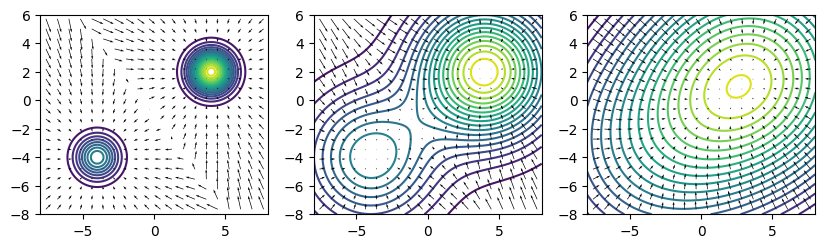

In [4]:
x_fine = np.linspace(-8.0, 8.0, 200)
y_fine = np.linspace(-8.0, 6.0, 200)
X, Y = np.meshgrid(x_fine, y_fine)

x_coarse = x_fine[5::10]
y_coarse = y_fine[5::10]
X_coarse, Y_coarse = np.meshgrid(x_coarse, y_coarse)
XY_coarse = np.stack((X_coarse, Y_coarse), -1)

def plot_density(ax, t):
    Z = mix.density(np.stack((X, Y), -1), t=t)
    ax.contour(X, Y, Z, levels=20)
    UV = mix.score(XY_coarse, t=t)
    U, V = UV[:, :, 0], UV[:, :, 1]
    ax.quiver(X_coarse, Y_coarse, U, V, zorder=2)
    ax.set_aspect("equal")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

plot_density(ax1, 0.0)
plot_density(ax2, 3.0)
plot_density(ax3, 6.0)

### Variance preserving (VP)

We choose $\alpha(t) = \frac{1}{2} \beta_d t^2 + \beta_\mathrm{min} t$ with $\beta_d = \beta_\mathrm{max} - \beta_\mathrm{min}$, such that $\alpha'(t) = \beta(t) = \beta_d t + \beta_\mathrm{min}$ is a linear interpolation between $\beta_\mathrm{min}$ and $\beta_\mathrm{max}$ for $t \in [0, 1]$. The VP choice is then
$$ \begin{array}{lcl}
a(t) = -\frac{1}{2}\alpha'(t) &\quad\Leftrightarrow\quad& s(t) = e^{-\frac12 \alpha(t)} = \frac{1}{\sqrt{e^{\alpha(t)}}} \\
b(t) = 0 &\quad\Leftrightarrow\quad& \mu(t) = 0 \\
g(t) = \sqrt{\alpha'(t)} &\quad\Leftrightarrow\quad& \sigma(t) = \sqrt{e^{\alpha(t)} - 1}
\end{array} $$

With this form, computing $s(t)$ and $\sigma(t)$ separately before computing the product $s(t)\sigma(t)$ may introduce rounding errors. To avoid this, we should perhaps introduce $\Sigma(t) = s(t) \sigma(t) = \sqrt{1 - e^{-\alpha(t)}}$.

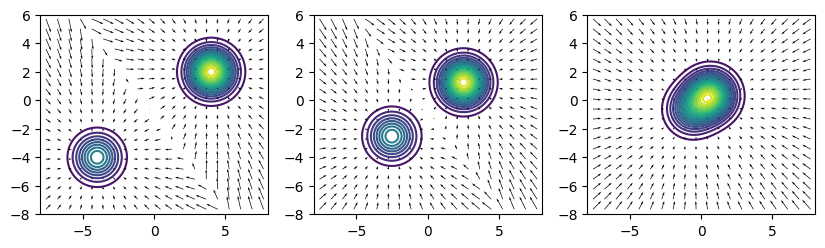

In [5]:
def alpha_vp(t, beta_min=0.1, beta_d=19.9):  # end of p.30 of EDM: beta_max = 20.0
    return (0.5 * beta_d * t + beta_min) * t

def scaling_vp(t):
    return np.exp(-0.5 * alpha_vp(t))

def drift_vp(t):
    return 0.0

def sigma_vp(t):
    return np.sqrt(np.exp(alpha_vp(t)) - 1.0)

norm1 = TimeEvolIsotropicMultivariateNormal(2, np.array([-4.0, -4.0]), 1.0, scaling_vp, drift_vp, sigma_vp)
norm2 = TimeEvolIsotropicMultivariateNormal(2, np.array([4.0, 2.0]), 1.0, scaling_vp, drift_vp, sigma_vp)
mix = Mixture((norm1, norm2), (1.0, 2.0))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

plot_density(ax1, 0.0)
plot_density(ax2, 0.3)
plot_density(ax3, 0.6)

### Sub-VP

With the same $t \mapsto \alpha(t)$ as previously,
$$ \begin{array}{lcl}
a(t) = -\frac{1}{2}\alpha'(t) &\quad\Leftrightarrow\quad& s(t) = e^{-\frac12 \alpha(t)} = 1/\sqrt{e^{\alpha(t)}} \\
b(t) = 0 &\quad\Leftrightarrow\quad& \mu(t) = 0 \\
g(t) = \sqrt{\alpha'(t) (1 - e^{-2\alpha(t)})} &\quad\Leftrightarrow\quad& \sigma(t) = e^{\frac12\alpha(t)} - e^{-\frac12\alpha(t)}
\end{array} $$
(Remark: this is wrong in the tutorial by Holderrieth. The correct reference is Song et al)

The computation for $\sigma$ is detailed
$$
\sigma(t)^2
= \int_0^t e^{\alpha(\tau)} \alpha'(\tau) (1 - e^{-2\alpha(\tau)}) \mathrm{d}\tau
= \int_0^t \alpha'(\tau) (e^{\alpha(\tau)} - e^{-\alpha(\tau)}) \mathrm{d}\tau
= e^{\alpha(t)} + e^{-\alpha(t)} - 2
= (e^{\frac12\alpha(t)} - e^{-\frac12\alpha(t)})^2
$$

In this case, $\Sigma(t) = s(t) \sigma(t) = 1 - e^{-\alpha(t)}$.

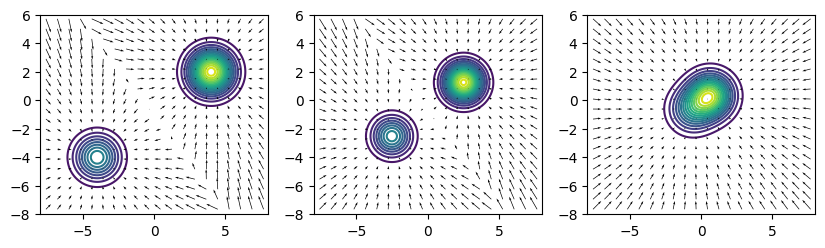

In [6]:
def scaling_subvp(t):
    return np.exp(-0.5 * alpha_vp(t))

def drift_subvp(t):
    return 0.0

def sigma_subvp(t):
    return 2.0 * np.sinh(0.5 * alpha_vp(t))

norm1 = TimeEvolIsotropicMultivariateNormal(2, np.array([-4.0, -4.0]), 1.0, scaling_subvp, drift_subvp, sigma_subvp)
norm2 = TimeEvolIsotropicMultivariateNormal(2, np.array([4.0, 2.0]), 1.0, scaling_subvp, drift_subvp, sigma_subvp)
mix = Mixture((norm1, norm2), (1.0, 2.0))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

plot_density(ax1, 0.0)
plot_density(ax2, 0.3)
plot_density(ax3, 0.6)